# Static Bandits

In [1]:
from collections import defaultdict
#from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.random import choice
import pandas as pd
from random import random
import random
import scipy.stats as stats
import seaborn as sb

//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## bandit classes

In [2]:
class AB(object):
    def __init__(self, n_arms, 
                 default_count=1.0, 
                 default_value=1.0,
                stop_after=30):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value
        self.counter = 0
        self.stop_after = stop_after

    def choose_arm(self):
        self.counter = (self.counter + 1) % self.n
        counts = sorted([(self.counts[arm], arm) for arm in range(self.n)])
        if counts[0][0] < self.stop_after:
            return counts[0][1]
        else:# self.counter > self.n*self.stop_after:
            return np.argmax(self.values)

    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value
        self.counter = 0
        
    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value 
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        return zip(self.values, np.zeros(self.n))

In [3]:
class Greedy(object):
    def __init__(self, n_arms, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value

    def choose_arm(self):
        return np.argmax(self.values)

    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value
        
    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value 
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        return zip(self.values, np.zeros(self.n))

In [4]:
class EpsilonGreedy(object):
    def __init__(self, n_arms, epsilon=0.1, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.epsilon = epsilon
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value

    def choose_arm(self):
        if np.random.random() > self.epsilon:
            return np.argmax(self.values)
        else:
            return np.random.randint(self.n)

    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value
        
    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value 
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        return zip(self.values, np.zeros(self.n))

In [5]:
class EpsilonDecreasing(object):
    def __init__(self, n_arms, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.epsilon = (2*self.n)
        self.epsilon /= (self.counts.sum() + 2*self.n)
        self.default_count = default_count
        self.default_value = default_value

    def choose_arm(self):
        self.epsilon = (2*self.n)
        self.epsilon /= (self.counts.sum() + 2*self.n)
        if np.random.random() > self.epsilon:
            return np.argmax(self.values)
        else:
            return np.random.randint(self.n)

    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value
        
    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        return zip(self.values, np.zeros(self.n))

In [6]:
class UCB(object):
    def __init__(self, n_arms=2, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value
        self.delta = 0.015

    def choose_arm(self):
        ucbs = [0.]*self.n
        T = self.counts.sum()
        for i in range(self.n):
            p = self.values[i]
            n = self.counts[i]
            ucb = p + self.delta*sqrt(2*T/n)
            ucbs[i] = ucb
        return np.argmax(ucbs)
    
    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value

    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value 
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        ci = np.zeros(self.n)
        T = self.counts.sum()
        for i in range(self.n):
            p = self.values[i]
            n = self.counts[i]
            ci[i] = self.delta*sqrt(2*T/float(n))
        return zip(self.values, ci)

In [7]:
class Bayesian(object):
    def __init__(self, n_arms=2, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value
        self.delta = 0.015

    def choose_arm(self):
        rvs = np.zeros(self.n)
        for i in range(self.n):
            rvs[i] = np.random.beta(self.default_value+self.values[i],
                               self.default_count+self.counts[i]-self.values[i])
        return np.argmax(rvs)
    
    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += reward
    
    def get_arm_data(self):
        expected_values = np.zeros(self.n)
        for i in range(self.n):
            a = self.default_value + self.values[i]
            b = self.default_count + self.counts[i] - self.values[i]
            expected_values[i] = a/(a+b)
        return zip(expected_values, np.zeros(self.n))

In [20]:
class Bayesian2(object):
	def __init__(self, n_arms=2, 
				 default_alpha=1.0, 
				 default_beta=1.0,
				 C=5):
		self.n = n_arms
		self.C = C
		self.default_alpha = default_alpha
		self.default_beta = default_beta
		self.arms = {}
		for i in range(self.n):
			self.arms[i] = {}
			self.arms[i]['a'] = self.default_alpha
			self.arms[i]['b'] = self.default_beta
		
    def choose_arm(self):
        return choose_arms(1)[0]
        
	def choose_arms(self, k_arms):
		res = []
		for i in range(self.n):
			res.append(np.random.beta(self.arms[i]['a'], self.arms[i]['b']), i)
		return [e[1] for e in sorted(res, reverse=True)[:k_arms]]
	
	def add_arm(self):
		self.n += 1
		arm_id = self.n
		self.arms[arm_id] = {}
		self.arms[arm_id]['a'] = self.default_alpha
		self.arms[arm_id]['b'] = self.default_beta
		return arm_id

	def reset_arm(self, arm_id):
		self.arms[arm_id]['a'] = self.default_alpha
		self.arms[arm_id]['b'] = self.default_beta
		
	def update(self, arm_id, reward):
		if reward == 0:
			if self.arms[arm_id]['a'] + self.arms[arm_id]['b'] < self.C:
				self.arms[arm_id]['b'] += 1.0
			elif self.arms[arm_id]['a'] + self.arms[arm_id]['b'] == self.C:
				if self.arms[arm_id]['b'] == self.C - 1:
					return
				else:
					self.arms[arm_id]['b'] += 1.0
					self.arms[arm_id]['a'] = max(self.default_alpha, 
						self.arms[arm_id]['a']-1.0)
	
		elif reward == 1:
			if self.arms[arm_id]['a'] + self.arms[arm_id]['b'] < self.C:
				self.arms[arm_id]['a'] += 1.0
			elif self.arms[arm_id]['a'] + self.arms[arm_id]['b'] == self.C:
				# if a is already at its max
				if self.arms[arm_id]['a'] == self.C - 1:
					return
				# else, inc a, reduce b as low as possible
				else:
					self.arms[arm_id]['a'] += 1.0
					self.arms[arm_id]['b'] = max(self.default_beta, 
						self.arms[arm_id]['b']-1.0)

	def get_arm_data(self):
		expected_values = np.zeros(self.n)
		for i in range(self.n):
			a = self.arms[i]['a']
			b = self.arms[i]['b']
			expected_values[i] = a/(a+b)
		return zip(expected_values, np.zeros(self.n))


IndentationError: unindent does not match any outer indentation level (<ipython-input-20-e8370a41f5ef>, line 16)

## generating static data

In [13]:
def gen_static_uniform(k = 2, T = 10):
    temp = np.random.rand(k)
    rewards = np.zeros((T, k))
    for t in range(T):
        rewards[t] += temp
    return rewards
#print gen_static_uniform()
print(gen_static_uniform())

[[ 0.4997398   0.89322499]
 [ 0.4997398   0.89322499]
 [ 0.4997398   0.89322499]
 [ 0.4997398   0.89322499]
 [ 0.4997398   0.89322499]
 [ 0.4997398   0.89322499]
 [ 0.4997398   0.89322499]
 [ 0.4997398   0.89322499]
 [ 0.4997398   0.89322499]
 [ 0.4997398   0.89322499]]


In [12]:
def gen_static_beta(k = 2, T = 10, a = 1, b = 100):
    temp = np.random.beta(a, b, k)
    rewards = np.zeros((T, k))
    for t in range(T):
        rewards[t] += temp
    return rewards
#print gen_static_beta()
print(gen_static_beta())

[[ 0.01513183  0.01234033]
 [ 0.01513183  0.01234033]
 [ 0.01513183  0.01234033]
 [ 0.01513183  0.01234033]
 [ 0.01513183  0.01234033]
 [ 0.01513183  0.01234033]
 [ 0.01513183  0.01234033]
 [ 0.01513183  0.01234033]
 [ 0.01513183  0.01234033]
 [ 0.01513183  0.01234033]]


## visualizing static data

In [14]:
def plot_static(actual, title='uniform',
               figsize = (10,5),
               colormap = plt.cm.cool,
               axis = None):
    if not axis:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        ax = axis
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('time step', fontsize=14)
    ax.set_ylabel('rewards', fontsize=14)
    ax.grid('off')
    ax.set_axis_bgcolor('white')
    xs = range(actual.shape[0])
    k = actual.shape[1]
    #labels = []
    for i in range(k):
        color = colormap(float(i)/k)
        ax.plot(xs, actual[:,i].tolist(), 
                c=color, alpha=1.0,
                label=str(i)+' actual', linewidth=2)
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    #return labels

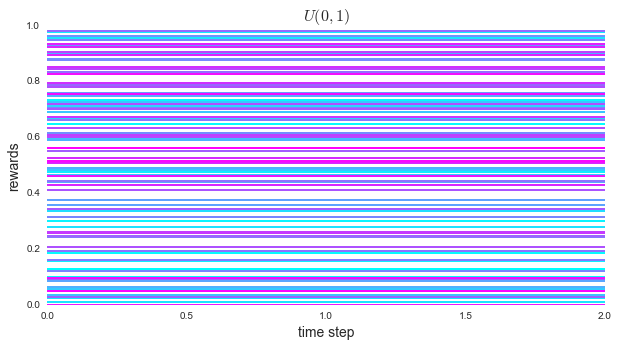

In [15]:
k = 100
actual = gen_static_uniform(k, 3)
plot_static(actual, r'$ U(0,1)$')

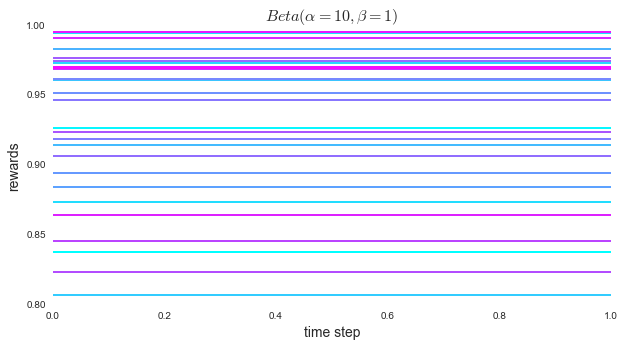

In [16]:
a, b = 10, 1
k = 30
actual = gen_static_beta(k=k, T=2, a=a, b=b)
plot_static(actual, r'$ Beta(\alpha='+str(a)+r',\beta='+str(b)+')$')

## visualizing regret

In [19]:
# test static, non-volatile data
def test_static(k = 2, T = 10, 
                actual = None, 
                bandit = None):
    rewards = np.zeros(T)
    arm_data = []
    regret = np.zeros(T)
    arms_selected = np.zeros((T, k))
    choices = range(k)
    for t in range(T):
        arm = bandit.choose_arm()
        actual_best = np.max(actual[t])
        reward = 0.0
        if actual[t][arm] > np.random.random():
            reward = 1.0
        rewards[t] = reward
        regret[t] = (t+1)*actual_best - rewards.sum()
        arm_data.append(bandit.get_arm_data())
        bandit.update(arm, reward)
    arm_data = np.array(arm_data)
    regret = np.array(regret)
    return rewards, arm_data, regret

def do_sims(bandits, n_sims=10, k=20, T=100, data_gen=gen_static_uniform, 
            params=None):
    if data_gen == gen_static_beta:
        a, b = params['a'], params['b']
    ts = pd.Series(range(T))
    df_final = None
    for sim in range(n_sims):
        if data_gen == gen_static_beta:
            actual = data_gen(k, T, a, b)
        else:
            actual = gen_static_uniform(k, T)
        for i, bandit in enumerate(bandits):
            bandit = bandit(k)
            rewards, arm_data, regret = test_static(k, T, actual, bandit)
            rewards = rewards.tolist()
            df = pd.DataFrame(ts, columns=['time'])
            df['policy'] = [bandit.__class__.__name__]*T
            df['regret'] = regret
            df['sim'] = pd.Series([sim]*T)
            if df_final is None:
                df_final = df
            else:
                df_final = pd.concat([df_final, df], ignore_index=True)
    fig, ax = plt.subplots(figsize=(15,8), dpi=200)
    ax.set_title('regret over time, k = '+str(k)+', sims = '+str(n_sims), 
                 fontsize=16)
    sb.set_palette('colorblind')
    sb.set_style("whitegrid")
    sb.tsplot(df_final, time='time', unit='sim', value='regret', 
              condition='policy', 
              ci=1, ax=ax)
    ax.set_xlabel('time step', fontsize=14)
    ax.set_ylabel('regret', fontsize=14)
    
bandits = [Greedy, EpsilonGreedy, EpsilonDecreasing, UCB, Bayesian, Bayesian2,
           AB]
params = {'a': 2, 'b': 10}
for k in [2, 4, 8, 16]:
    #do_sims(bandits, n_sims=10, k=k, T=100, data_gen=gen_static_uniform)
    do_sims(bandits, 50, k, 50, gen_static_beta, params)

# k = 2
# bayes better when data is distributed beta(1,20)
# ucb better when data is distributed beta(1,10)
# ep-decr better when data is distributed beta(1,1)
# ucb better when data is distributed beta(10,1)
# ucb better when data is distributed beta(20,1)

#k = 4
# ucb better when data is distributed beta(1,1)

#k = 10
# ucb better when data is distributed beta(1,1)
# ucb better when data is distributed beta(10,1)
# ucb better when data is distributed beta(1,10)


AttributeError: 'Bayesian2' object has no attribute 'choose_arm'

## plotting bandit beliefs

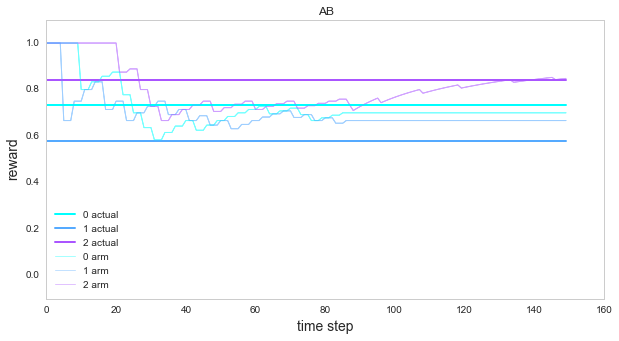

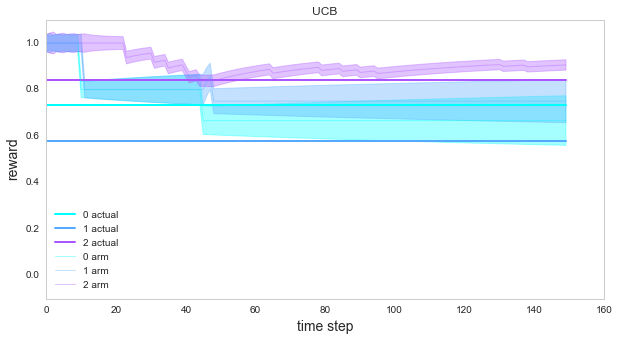

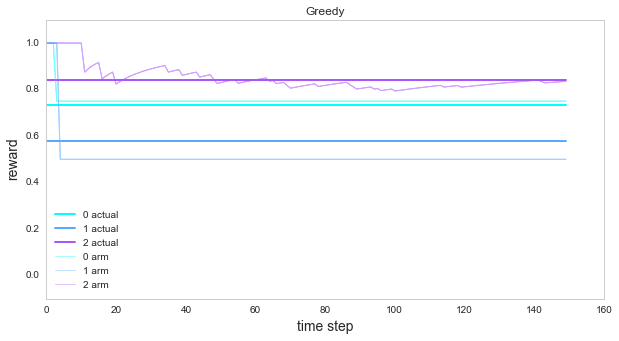

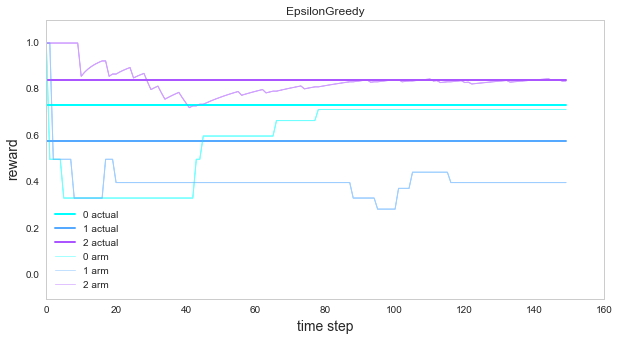

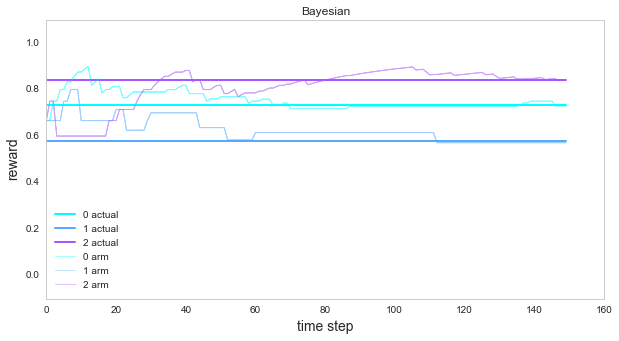

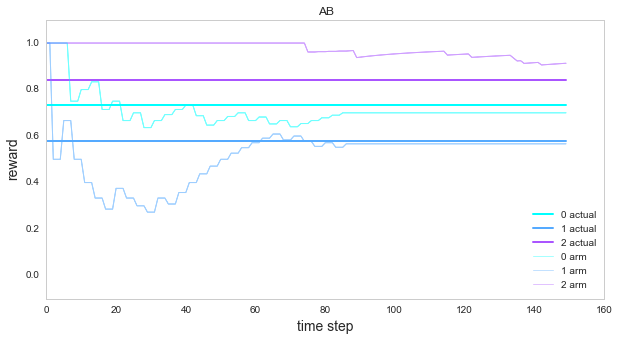

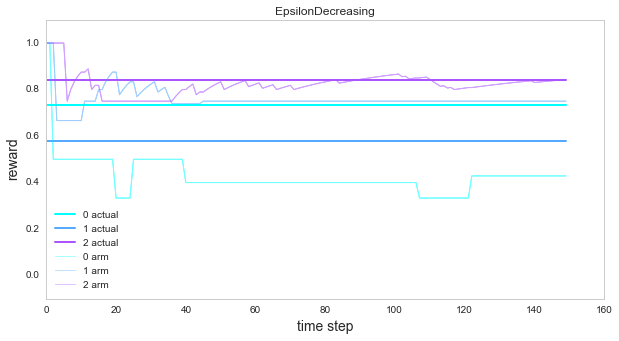

In [26]:
def plot_arm_data_plus_actual(arm_data, actual, 
                              figsize=(10,5), 
                              #figsize=(15,8.45),
                              colormap = plt.cm.cool,
                              fig_title='title'):
    #plt.clf()
    fig, ax = plt.subplots(figsize=figsize)
    labels = plot_static(actual, axis=ax)
    ax.set_title(fig_title);
    ax.grid('off')
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('time step'); ax.set_ylabel('reward')
    k = arm_data.shape[1]
    xs = range(len(arm_data))
    for i in range(k):
        color = colormap(i/float(k))
        ys = np.array([e[i][0] for e in arm_data])
        err = np.array([(e[i][1]) for e in arm_data])
        h = ax.plot(xs, ys, color=color, alpha=0.35, label=str(i)+' arm', linewidth=1)
        ax.fill_between(xs, ys+err, ys-err, color=color, alpha=0.35, linewidth=1)
    ax.legend(loc='best')

def demo_bandits():
    k, T = 3, 150
    actual = gen_static_uniform(k, T)
    bandits = [AB(k),
               UCB(n_arms=k),
               Greedy(k),
               EpsilonGreedy(k, 0.1),
               Bayesian(k), AB(k),
               EpsilonDecreasing(k)
              ]
    for b in bandits:
        rewards, arm_data, regret = test_static(k, T, 
                                                actual, b)
        bandit_name = b.__class__.__name__
        plot_arm_data_plus_actual(arm_data, actual, 
                                  fig_title=bandit_name)
demo_bandits()

## parameter tuning using hyperopt

In [27]:
space_epsilon_greedy = {
    'e': hp.uniform('e', 0.0, 1.0)
}
k, T = 20, 500
#k, T = 3, 100

def f(a):
    e = a['e']
    #actual = gen_static_uniform(k, T)
    actual = gen_static_beta(k, T, a=10, b=1)
    #print actual
    bandit = EpsilonGreedy(n_arms=k, epsilon=e)
    rewards, arm_data, regret = test_static(k, T, actual, bandit)
    #print regret
    return {'loss': regret.mean(), 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space_epsilon_greedy, algo=tpe.suggest, max_evals=1000, trials=trials)
print best
#for trial in trials.trials:
#    print trial
f, ax = plt.subplots(figsize=(5,5))
xs = [t['tid'] for t in trials.trials]
#ys = [t['result']['loss'] for t in trials.trials]
cmap = plt.cm.jet
xs = np.array([t['misc']['vals']['e'] for t in trials.trials]).ravel()
ys = [t['result']['loss'] for t in trials.trials]
#print ys
xs, ys = zip(*sorted(zip(xs, ys)))
#print xs
print np.min(ys), np.max(ys)
ax.set_xlim(xs[0]-0.1, xs[-1]+0.1)
#ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.85, c=map(lambda x: cmap(x), xs)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_title('epsilson')
# 500 evals
# k, T = 2, 500: {'e': 0.09747575020458313}
# k, T = 4, 500: {'e': 0.03270717406841881}
# k, T = 10, 500: {'e': 0.043947921169053654}
# k, T = 20, 500: {'e': 0.000338458854921297}
# k, T = 50, 500: {'e': 3.096403594072899e-05}

# 1000 evals
# k, T = 2, 500: {'e': 0.0003479380548632449}
# k, T = 10, 500: {'e': 0.00014528134554619293}
# k, T = 20, 500: {'e': 0.0010218330670631536}

# beta(1,10)
# k, T = 2, 500: {'e': 0.13245564986616667}
# k, T = 10, 500: {'e': 0.06829021319738379}

# k, T = 20, 500: {'e': 0.15905617104145692}

# beta(10,1)
# k, T = 20, 500: {'e': 0.017869008912391172 }


NameError: name 'hp' is not defined

## demos: animal faces and button colors

In [139]:
def test_static_animalfaces(k, T, actual, bandit):
    rewards = []
    arm_data = []
    regret = []
    arms_selected = np.zeros(T)
    for t in range(T):
        arm = bandit.choose_arm()
        arms_selected[t] = arm
        actual_best = np.max(actual[t])
        reward = 0.0
        if actual[t][arm] > np.random.random():
            reward = 1.0
        regret.append(actual_best - reward)
        rewards.append(reward)
        arm_data.append(bandit.get_arm_data())
        bandit.update(arm, reward)
    rewards = np.array(rewards)
    arm_data = np.array(arm_data)
    regret = np.array(regret)
    return rewards, arm_data, regret, arms_selected

def demo_bandits_animalfaces():
    catface = '\xF0\x9F\x90\xB1'
    pandaface = '\xF0\x9F\x90\xBC'
    monkeyface = '\xF0\x9F\x90\xB5'
    babychick = '\xF0\x9F\x90\xA4'
    animals = [catface, pandaface, monkeyface]
    print 'animals:', ' '.join(animals)
    k, T = len(animals), 15
    actual = gen_static_uniform(k, T)
    print 'true rewards:', actual[0]
    bandits = [UCB(n_arms=k),
               Greedy(k),
               EpsilonGreedy(k, 0.1),
               EpsilonDecreasing(k),
              Bayesian(k),
              AB(k)]
    besti = np.argmax(actual[0])
    best = animals[besti]
    print ''
    res = []
    for i, b in enumerate(bandits):
        rewards, arm_data, regret, arms_selected = test_static_animalfaces(k, T, actual, b)
        bandit_name = b.__class__.__name__
        df = pd.DataFrame(rewards, columns=['rewards'])
        df['arm selected'] = arms_selected
        df['time step'] = range(1, T+1)
        df = df.pivot('arm selected', 'time step', 'rewards')
        df = df.fillna('')
        print bandit_name
        print df
        print ''
    return
#    df = pd.DataFrame(res, columns=['policy', 'T', '% correct'])
#    df = df.sort('T')
#    df = df.pivot('policy','T', '% correct')
    print df
demo_bandits_animalfaces()

animals: 🐱 🐼 🐵
true rewards: [ 0.40137985  0.65782376  0.95168193]

UCB
time step    1  2  3  4  5  6  7  8  9  10 11 12 13 14 15
arm selected                                             
0             0                                          
1                1     1     1     1     1     0         
2                   1     1     1     1     1     1  1  1

Greedy
time step    1  2  3  4  5  6  7  8  9  10 11 12 13 14 15
arm selected                                             
0             0                                          
1                0                                       
2                   1  1  1  1  1  0  1  1  1  1  1  1  1

EpsilonGreedy
time step    1  2  3  4  5  6  7  8  9  10 11 12 13 14 15
arm selected                                             
0             1  1  0                                0   
1                      1  1  1  1  1  1  1  1  0         
2                                                 1     1

EpsilonDecreasing
time step    1  

In [135]:
def test_static_animalfaces(k, T, actual, bandit):
    rewards = []
    arm_data = []
    regret = []
    arms_selected = np.zeros(T)
    for t in range(T):
        arm = bandit.choose_arm()
        arms_selected[t] = arm
        actual_best = np.max(actual[t])
        reward = 0.0
        if actual[t][arm] > np.random.random():
            reward = 1.0
        regret.append(actual_best - reward)
        rewards.append(reward)
        arm_data.append(bandit.get_arm_data())
        bandit.update(arm, reward)
    rewards = np.array(rewards)
    arm_data = np.array(arm_data)
    regret = np.array(regret)
    return rewards, arm_data, regret, arms_selected

def demo_bandits_animalfaces():
    catface = '\xF0\x9F\x90\xB1'
    pandaface = '\xF0\x9F\x90\xBC'
    monkeyface = '\xF0\x9F\x90\xB5'
    babychick = '\xF0\x9F\x90\xA4'
    animals = [catface, pandaface, monkeyface]
    print 'animals:', ' '.join(animals)
    k, T = len(animals), 30
    actual = gen_static_uniform(k, T)
    print 'rewards:', actual[0], '\n'
    bandits = [UCB(n_arms=k),
               Greedy(k),
               EpsilonGreedy(k, 0.1),
               EpsilonDecreasing(k),
              Bayesian(k),
              AB(k)]
    besti = np.argmax(actual[0])
    best = animals[besti]
    print 'best:'+ ''.join([' ']*(len('EpsilonDecreasing:')-len('best:'))) +''.join([best]*T)
    print ''
    res = []
    for i, b in enumerate(bandits):
        rewards, arm_data, regret, arms_selected = test_static_animalfaces(k, T, actual, b)
        bandit_name = b.__class__.__name__
        selected = ''.join([animals[int(a)] for a in arms_selected])
        padding = ''.join([' ']*(len('EpsilonDecreasing:')-len(bandit_name)-1))
        print bandit_name+':' + padding + selected# + ' ' + str(n_correct) + '/' + str(T)

demo_bandits_animalfaces()

animals: 🐱 🐼 🐵
rewards: [ 0.84169441  0.59120343  0.42810959] 

best:             🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱

UCB:              🐱🐼🐵🐱🐼🐵🐱🐵🐱🐵🐱🐵🐱🐵🐱🐵🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱
Greedy:           🐱🐼🐼🐵🐼🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱
EpsilonGreedy:    🐱🐼🐼🐼🐵🐼🐼🐼🐼🐼🐵🐼🐼🐼🐼🐼🐼🐼🐱🐱🐼🐱🐵🐱🐱🐱🐵🐱🐱🐱
EpsilonDecreasing:🐱🐼🐱🐼🐱🐱🐼🐱🐵🐱🐼🐼🐼🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐵🐱🐱🐱🐱🐱🐱
Bayesian:         🐼🐵🐼🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐵🐱🐼🐱🐱🐱🐱🐱🐱🐵🐱🐱🐱🐱🐱
AB:               🐼🐵🐱🐼🐵🐱🐼🐵🐱🐼🐵🐱🐼🐵🐱🐼🐵🐱🐼🐵🐱🐼🐵🐱🐼🐵🐱🐼🐵🐱


actual: [ 0.8873166   0.79378452  0.87838314  0.93547965  0.54833827  0.72916566
  0.26673868  0.40443108  0.37294334  0.96505332  0.25808288  0.22087548
  0.6261327   0.78889808  0.13001572  0.8352062   0.12397458  0.78185154
  0.65066941  0.53136373  0.59694619  0.31499414  0.48838972  0.45680156
  0.66463612  0.04793618  0.34460961  0.71446948  0.56599487  0.63424633] 

9


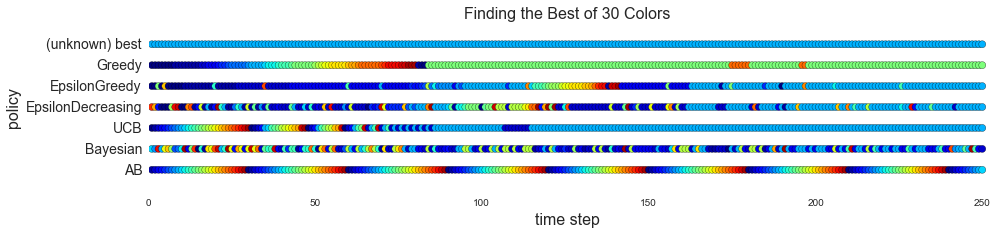

In [134]:
def test_static_animalfaces(k, T, actual, bandit):
    rewards = []
    arm_data = []
    regret = []
    #arms_selected = np.zeros((T, k))
    #choices = range(k)
    arms_selected = np.zeros(T)
    for t in range(T):
        arm = bandit.choose_arm()
        #print arm
        arms_selected[t] = arm
        actual_best = np.max(actual[t])
        reward = 0.0
        if actual[t][arm] > np.random.random():
            reward = 1.0
        regret.append(actual_best - reward)
        rewards.append(reward)
        arm_data.append(bandit.get_arm_data())
        bandit.update(arm, reward)
    rewards = np.array(rewards)
    arm_data = np.array(arm_data)
    regret = np.array(regret)
    return rewards, arm_data, regret, arms_selected

def demo_bandits_buttoncolors():
    k, T = 30, 250
    colors = list(map(lambda x: plt.cm.jet(float(x)/k), range(k)))
    actual = gen_static_uniform(k, T)
    print 'actual:', actual[0], '\n'
    bandits = [Greedy(k),
               EpsilonGreedy(k, 0.1),
               EpsilonDecreasing(k),
               UCB(n_arms=k),
               Bayesian(k),
               AB(k)]
    res = []
    ylabels = []
    f, ax = plt.subplots(1,figsize=(15,3), subplot_kw=dict(axisbg='white'))
    print np.argmax(actual)
    cs = [colors[np.argmax(actual)]]*T
    ax.scatter(range(1,T+1), [len(bandits)]*T, c=cs, s=50)
    ylabels.append('(unknown) best')
    for i, b in enumerate(bandits):
        rewards, arm_data, regret, arms_selected = test_static_animalfaces(k, T, actual, b)
        bandit_name = b.__class__.__name__
        #print bandit_name, arms_selected
        ylabels.append(bandit_name)
        cs = [colors[int(a)] for a in arms_selected]
        ax.scatter(range(1,T+1), [len(bandits)-i-1]*T, c=cs, s=50)#, alpha=0.5)
    
    ax.set_yticks(range(len(bandits)+1))
    ax.set_yticklabels(ylabels[::-1], fontsize=14)
    ax.set_ylabel('policy', fontsize=16)
    ax.set_xlabel('time step', fontsize=16)
    ax.set_xlim([0, T+1])
    ax.set_title('Finding the Best of '+str(k)+' Colors', fontsize=16)
    plt.savefig('circles'+str(k))
    
demo_bandits_buttoncolors()

In [114]:
class Bayesian2(object):
    def __init__(self, n_arms=2, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value
        self.delta = 0.015

    def choose_arm(self):
        rvs = np.zeros(self.n)
        for i in range(self.n):
#            X = np.random.beta(1+self.values[i],
#                               1+self.counts[i]-self.values[i])
            rvs[i] = np.random.beta(1+self.values[i],
                               1+self.counts[i]-self.values[i])
        return np.argmax(rvs)
    
    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += reward
    
    def get_arm_data(self):
        ab = []
        for i in range(self.n):
            a = self.default_value + self.values[i]
            b = self.default_count + self.counts[i] - self.values[i]
            ab.append((a,b))
        return ab

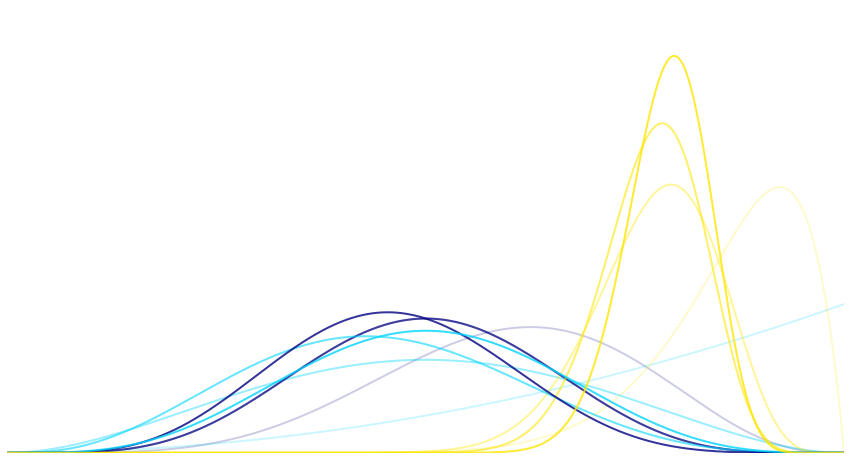

In [113]:
def plot_bayesian_arm_data(data):
    k = len(data[0])
    T = len(data)
    f, ax = plt.subplots(1, figsize=(15,8))
    ax.set_axis_bgcolor('white')
    cmap = plt.cm.jet
    x = np.linspace(0, 1, 1000)
    N = 5
    for t, d in enumerate(data[::T/N]):
        for i, (a,b) in enumerate(d):
            y = stats.beta.pdf(x, a, b)
            p = ax.plot(x, y, c=cmap(float(i)/len(d)), linewidth=2, alpha=float(t)/N)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

def plot_bayesian_bandit():
    k, T = 3, 100
    actual = gen_static_uniform(k, T)
    #actual = np.array([[0.15, 0.3, 0.45, 0.6, 0.75]]*T)
    a = np.linspace(0.2, 0.8, k).tolist()
    actual = np.array([a]*T)
    rewards, arm_data, regret = test_static(k, T, actual, Bayesian2(k))
    plot_bayesian_arm_data(arm_data)
    bandit_name = b.__class__.__name__

plot_bayesian_bandit()